### Get the data of the last two moths

In [2]:
# Notebook lasciato nella cartella recommender-system ma aggiunto mab ['s package folder to recomeender-system]
# per poter importare entrambi i moduli

from recommender_system import RedSQL, load_cfg
from mab import get_bandits_events
import time

In [6]:
t1=time.time()

cfg = load_cfg()

In [7]:
with RedSQL(cfg['redshift']) as rs:
    data = get_bandits_events(rs)

t2=time.time()
print(t2-t1)

KeyboardInterrupt: 

## a) Understand "compute_pulls"

In [4]:
# From file:///C:/Users/Arianna/Desktop/WORK/Notebook/mab_documentation/reference/process.html#mab.process.compute_pulls
# Needs updated dev credentials

from mab import compute_bandit_metrics, compute_pulls

In [11]:
pulls = compute_pulls(data)
metrics = compute_bandit_metrics(pulls)
metrics

{'version-v2.3.0': {'a': 4195.3270136125675, 'b': 95804.67298638744}}

In [3]:
# To distinguish the data, we use algorithm's tags

from mab.tag import TypeTag

In [ ]:
pulls = compute_pulls(data, tag_extractor=TypeTag())
metrics = compute_bandit_metrics(pulls)
metrics

{'EventPeople': {'a': 4157.873844139135, 'b': 95842.12615586087},
 'Planning': {'a': 4883.161915724747, 'b': 95116.83808427525},
 'Exhibitor': {'a': 5047.081246895681, 'b': 94952.91875310431},
 'CommunityProfile': {'a': 0.01, 'b': 3636},
 'Product': {'a': 5708, 'b': 89535}}

In [5]:
# Clearer with ratios: probability of success

from mab.mab import ratios

ratios(metrics)

{'EventPeople': 0.0433242289110757,
 'Planning': 0.04979826524970406,
 'Exhibitor': 0.05109628768114442,
 'Product': 0.06093431884571125,
 'CommunityProfile': 2.746490671544434e-06}

## b) Modify "BanditStats"

In [3]:
# BanditStats (see Reference) is a class in mab.database to get the data from the database.
# It contains the parameter QUERY_DAYS and the method get_bandits_events

from datetime import datetime, timedelta
from recommender_system.database.templates import RSTemplate
from mab.filter import sanitize_filter

QUERY_DAYS = 15
"""How far in the past we seek for data"""

'How far in the past we seek for data'

In [6]:
class BanditStats(RSTemplate):
    query = """
    select type, user_id, platform, "time", properties from raw_tracking.v2 where type in ($types)
    and time between '$start' and '$end' order by time;
    """

    # Schema "raw_tracking", relation "v2"

def get_bandits_events(rs, query_days=None, now=None, keep_filter=None, no_similar=True, no_remove=True):
    if query_days is None:
        query_days = QUERY_DAYS
    if now is None:
        now = datetime.now()
    if keep_filter is None:
        keep_filter = sanitize_filter
    start = now - timedelta(days=query_days)
    carousel_type = "'recommendation_carousel_show'"
    items = ['person', 'planning', 'product', 'exhibitor']
    e_type = ['recommended'] if no_similar else ['recommended', 'similar']
    e_action = ['open'] if no_remove else ['open', 'remove']
    types = ', '.join([carousel_type] + [f"'{t}_{i}_{a}'" for t in e_type for i in items for a in e_action])
    # f-string for formatting; see https://realpython.com/python-f-strings/#:~:text=Also%20called%20formatted%20string%20literals,expressions%20with%20their%20resulting%20values.
    
    return [r for r in BanditStats.get(rs, start=start, end=now, types=types) if keep_filter(r)]

In [4]:
# Modified version of BanditStats that retrieves also the event_id 

from datetime import datetime, timedelta
from recommender_system.database.templates import RSTemplate
from mab.filter import sanitize_filter

QUERY_DAYS = 15
"""How far in the past we seek for data"""


class mod_BanditStats(RSTemplate):
    query = """
    select type, user_id, platform, "time", event_id, properties from raw_tracking.v2 where type in ($types)
    and time between '$start' and '$end' order by time;
    """
    #Aggiunto event_id

def mod_get_bandits_events(rs, query_days=None, now=None, keep_filter=None, no_similar=True, no_remove=True):
    if query_days is None:
        query_days = QUERY_DAYS
    if now is None:
        now = datetime.now()
    if keep_filter is None:
        keep_filter = sanitize_filter
    start = now - timedelta(days=query_days)
    carousel_type = "'recommendation_carousel_show'"
    items = ['person', 'planning', 'product', 'exhibitor']
    e_type = ['recommended'] if no_similar else ['recommended', 'similar']
    e_action = ['open'] if no_remove else ['open', 'remove']
    types = ', '.join([carousel_type] + [f"'{t}_{i}_{a}'" for t in e_type for i in items for a in e_action])
    return [r for r in mod_BanditStats.get(rs, start=start, end=now, types=types) if keep_filter(r)]

In [8]:
#no:   get_bandits_events(rs, no_similar=True, no_remove=True)

with RedSQL(cfg['redshift']) as rs:
    a=get_bandits_events(rs, no_similar=True, no_remove=True)
a

[{'type': 'recommendation_carousel_show',
  'user_id': 'VXNlcl8xMTA4Mjc1Mw==',
  'platform': 'web-user',
  'time': datetime.datetime(2024, 3, 21, 19, 45, 12, 993895, tzinfo=datetime.timezone.utc),
  'properties': {'source': 'attendee_view',
   'metadata': '{}',
   'is_initial': True,
   'event_view_id': 'RXZlbnRWaWV3XzU1MTA1NQ==',
   'visible_area_end': 0.37310000000000004,
   'visible_area_start': 0,
   'current_visible_ids': ['RXZlbnRQZW9wbGVfMjMwMzcwNjM=',
    'RXZlbnRQZW9wbGVfMjMwMzcxMTk=',
    'RXZlbnRQZW9wbGVfMjI0Mzc3OTM=',
    'RXZlbnRQZW9wbGVfMjQyMTQwNDY=']}},
 {'type': 'recommendation_carousel_show',
  'user_id': 'VXNlcl8xODk3MzA1OA==',
  'platform': 'web-user',
  'time': datetime.datetime(2024, 3, 21, 19, 45, 15, 426499, tzinfo=datetime.timezone.utc),
  'properties': {'source': 'attendee_view',
   'metadata': '{}',
   'is_initial': False,
   'event_view_id': 'RXZlbnRWaWV3XzQ3MDQ1Ng==',
   'visible_area_end': 1,
   'visible_area_start': 0.6174000000000001,
   'current_visible_

In [7]:
with RedSQL(cfg['redshift']) as rs:
    b=mod_get_bandits_events(rs, no_similar=True, no_remove=True)
b

[{'type': 'recommendation_carousel_show',
  'user_id': 'VXNlcl8xOTQ0OTA1OQ==',
  'platform': 'web-user',
  'time': datetime.datetime(2024, 5, 14, 15, 58, 52, 966346, tzinfo=datetime.timezone.utc),
  'event_id': 'RXZlbnRfMTgyNjU0MQ==',
  'properties': {'source': 'attendee_view',
   'metadata': '{}',
   'is_initial': False,
   'event_view_id': 'RXZlbnRWaWV3Xzc4NTU5MA==',
   'visible_area_end': 0.9825999999999999,
   'visible_area_start': 0.6,
   'current_visible_ids': ['RXZlbnRQZW9wbGVfMzA3ODM3MTc=',
    'RXZlbnRQZW9wbGVfMzAyNTA3Nzk=',
    'RXZlbnRQZW9wbGVfMjk4MDc1NjQ=',
    'RXZlbnRQZW9wbGVfMzA3ODUwMDU=']}},
 {'type': 'recommendation_carousel_show',
  'user_id': 'VXNlcl8xOTQ2ODcwNA==',
  'platform': 'web-user',
  'time': datetime.datetime(2024, 5, 14, 15, 58, 54, 759661, tzinfo=datetime.timezone.utc),
  'event_id': 'RXZlbnRfMTkyMzMxOQ==',
  'properties': {'source': 'attendee_view',
   'metadata': '{}',
   'is_initial': True,
   'event_view_id': 'RXZlbnRWaWV3Xzg0ODMyNQ==',
   'visible_ar

### EXTRA: Learn Base64

In [1]:
from recommender_system.engagement.utils import kind64decode, kind64decode, b64decode, b64encode

In [9]:
kind64decode('VXNlcl8xNzkwNjU0Mg==' )

('User', 17906542)

In [12]:
kind64decode('RXZlbnRQZW9wbGVfMjgwMzI2NzE=')

('EventPeople', 28032671)

## c) Modify "compute_pulls" so it outputs a list of tuples (timestamp, event_id, success)

In [9]:
from collections import defaultdict
from datetime import timedelta

from mab.filter import is_carousel, r2t
from mab.tag import AlgoTag


TIME_OUT=600
# Grace period (in seconds) for a pull to be considered successful"""

In [9]:
#compute_pulls

def compute_pulls(data, tag_extractor=None, time_out=TIME_OUT, store_time=False):
    if tag_extractor is None:
        tag_extractor = AlgoTag()
    immediate = timedelta(seconds=0)
    time_out = timedelta(seconds=time_out)

    # opens associates to each action a list of times when it was performed
    actions = defaultdict(list)
    # Usually, a Python dictionary throws KeyError if you try to get an item with a key that is not present.
    # defaultdict in contrast creates any items that you try to access; in this case using list(), which returns a new empty list
    
    # carousels associates to each tag a list of pulls.
    # Each carousel pull is a tuple made of a list of potential actions and a time.
    carousels = defaultdict(list)
    for r in data:
        if is_carousel(r):
            tag = tag_extractor(r)
            if tag is None:
                continue
            carousels[tag].append((r2t(r), r['time']))
        else:
            actions[r2t(r)].append(r['time'])

    pulls = dict()
    for tag, carousel in carousels.items():
        pulls[tag] = {'success': list()}
        if store_time:
            pulls[tag]['time'] = list()
        for c in carousel:
            ok = False
            for tup in c[0]:
                if tup in actions:
                    for ti in actions[tup]:
                        if immediate <= ti - c[1] <= time_out:
                            ok = True
                            break
                    if ok:
                        break
            pulls[tag]['success'].append(ok)
            if store_time:
                pulls[tag]['time'].append(c[1])
    return pulls

In [10]:
# Modified version 

def mod_compute_pulls(data, tag_extractor=None, time_out=TIME_OUT, store_time=True):
#store_time so that it outputs the timestamp
    
    if tag_extractor is None:
        tag_extractor = AlgoTag()
    immediate = timedelta(seconds=0)
    time_out = timedelta(seconds=time_out)

    # opens associates to each action a list of times when it was performed
    actions = defaultdict(list)
    # carousels associates to each tag a list of pulls.
    # Each carousel pull is a tuple made of a list of potential actions and a time.
    carousels = defaultdict(list)
    for r in data:
        if is_carousel(r):
            tag = tag_extractor(r)
            if tag is None:
                continue
            carousels[tag].append((r2t(r), r['time']))
        else:
            actions[r2t(r)].append(r['time'])

    pulls = dict()
    for tag, carousel in carousels.items():
        pulls[tag] = {'success': list()}
        if store_time:
            pulls[tag]['time'] = list()
        for c in carousel:
            ok = False
            for tup in c[0]:
                if tup in actions:
                    for ti in actions[tup]:
                        if immediate <= ti - c[1] <= time_out:
                            ok = True
                            break
                    if ok:
                        break
            pulls[tag]['success'].append(ok)
            if store_time:
                pulls[tag]['time'].append(c[1])
                
        return [(pulls['version-v2.3.0']['time'][i],
                 # event_id MISSING... b[i]['event_id'] gives "list index out of range",
                 data[i]['event_id'],
                 pulls['version-v2.3.0']['success'][i]) for i in range(len(pulls['version-v2.3.0']['success']))]
    # Tuples of timestamp, event_id, success

In [11]:
with RedSQL(cfg['redshift']) as rs:
    mod_data = mod_get_bandits_events(rs)

mod_data

[{'type': 'recommendation_carousel_show',
  'user_id': 'VXNlcl85ODA0ODQ2',
  'platform': 'web-user',
  'time': datetime.datetime(2024, 5, 14, 16, 0, 26, 585016, tzinfo=datetime.timezone.utc),
  'event_id': 'RXZlbnRfMTUyOTg4OQ==',
  'properties': {'source': 'session_view',
   'metadata': '{}',
   'is_initial': True,
   'event_view_id': 'RXZlbnRWaWV3Xzg0MDQ3MQ==',
   'visible_area_end': 0.5966,
   'visible_area_start': 0,
   'current_visible_ids': ['UGxhbm5pbmdfMTg5NjUyMg==',
    'UGxhbm5pbmdfMTg5NjUxOA==',
    'UGxhbm5pbmdfMTg5NjYwOA==']}},
 {'type': 'recommendation_carousel_show',
  'user_id': 'VXNlcl8yMzA3NDY1',
  'platform': 'web-user',
  'time': datetime.datetime(2024, 5, 14, 16, 0, 27, 425324, tzinfo=datetime.timezone.utc),
  'event_id': 'RXZlbnRfMTc3NDgzNw==',
  'properties': {'source': 'attendee_view',
   'metadata': '{}',
   'is_initial': True,
   'event_view_id': 'RXZlbnRWaWV3Xzc0MjcxMg==',
   'visible_area_end': 0.1446,
   'visible_area_start': 0,
   'current_visible_ids': ['R

In [12]:
mod_pulls = mod_compute_pulls(mod_data)
mod_pulls

[(datetime.datetime(2024, 5, 14, 16, 0, 26, 585016, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMTUyOTg4OQ==',
  False),
 (datetime.datetime(2024, 5, 14, 16, 0, 27, 425324, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMTc3NDgzNw==',
  False),
 (datetime.datetime(2024, 5, 14, 16, 0, 27, 571020, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMTg1NjIxMA==',
  False),
 (datetime.datetime(2024, 5, 14, 16, 0, 28, 406840, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMTg0OTU3NA==',
  False),
 (datetime.datetime(2024, 5, 14, 16, 0, 28, 736152, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMTY5NTk1NA==',
  False),
 (datetime.datetime(2024, 5, 14, 16, 0, 30, 308625, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMTA2MjQzOA==',
  False),
 (datetime.datetime(2024, 5, 14, 16, 0, 30, 650234, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMTc5NDgxMA==',
  True),
 (datetime.datetime(2024, 5, 14, 16, 0, 31, 150742, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMTg0OTU3NA==',
  False),
 (datetime.datetime(2024, 5, 14, 16, 0, 31, 90987

## d) For all recent events: collect the type, sector, category, time_zone, and size

In [13]:
# recent = created >=2023 [Communities.get(rs, freshness=48)]
# All but size are in [raw_core.]core_event_v2 [che sono eventi]
# For the size, learn how to do a unique count on [raw_core.]core_event_profile 

#20240528 error no access: use core_event_v2_scd instead

class info(RSTemplate):
    query = """
    SELECT id, type, sector, category, timezone
    FROM raw_core.core_event_v2_scd                                       
    WHERE created_at between '2024-01-01 00:00:00.000000' AND CURRENT_TIMESTAMP
    ORDER BY id;
    """

def collect_info(rs):
    return info.get(rs)

In [14]:
with RedSQL(cfg['redshift']) as rs:
    coll_data = collect_info(rs)

coll_data

[{'id': 1765467,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 {'id': 1765468,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 {'id': 1765508,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 {'id': 1765509,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 {'id': 1765558,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 {'id': 1765559,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 {'id': 1765571,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 {'id': 1765572,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 {'id': 1765584,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 {'id': 1765585,
  'type': '

In [20]:
len(coll_data)

13845

In [21]:
[i['category'] for i in coll_data if i['category'] != None]

['CONFERENCE',
 'CONFERENCE',
 'EXHIBITION',
 'CORPORATE_EVENT',
 'OTHER',
 'CONFERENCE',
 'CONFERENCE',
 'EXHIBITION',
 'EXHIBITION',
 'CONFERENCE',
 'OTHER',
 'OTHER',
 'OTHER',
 'OTHER',
 'OTHER',
 'CONFERENCE',
 'EXHIBITION',
 'CONFERENCE',
 'CORPORATE_EVENT',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'OTHER',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'EXHIBITION',
 'OTHER',
 'OTHER',
 'CONFERENCE',
 'CONGRESS',
 'CONGRESS',
 'CORPORATE_EVENT',
 'CONFERENCE',
 'CONFERENCE',
 'OTHER',
 'CONFERENCE',
 'EXHIBITION',
 'OTHER',
 'EXHIBITION',
 'CONFERENCE',
 'CORPORATE_EVENT',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CORPORATE_EVENT',
 'OTHER',
 'CONFERENCE',
 'OTHER',
 'CONFERENCE',
 'OTHER',
 'OTHER',
 'CONFERENCE',
 'CORPORATE_EVENT',
 'CORPORATE_EVENT',
 'CONGRESS',
 'CORPORATE_EVENT',
 'CORPORATE_EVENT',
 'CORPORATE_EVEN

In [15]:
# Size: UNIQUE (=distinct) COUNT in raw_core.core_event_profile [which are participants, NOT recommendations], i.e. number of participants per event 

class size(RSTemplate):
    query = """
    --Counting the number of distinct values in the 'prod' column 
    SELECT event_id, COUNT(*)
    
    --From the 'raw_core.core_event_profile' table
    FROM raw_core.core_event_profile

    WHERE created_at between '2024-01-01 00:00:00.000000' AND CURRENT_TIMESTAMP
    
    GROUP BY event_id
    
    ORDER BY event_id;
    """

def collect_size(rs):
    return size.get(rs)

In [16]:
with RedSQL(cfg['redshift']) as rs:
    size_data = collect_size(rs)

size_data

[{'event_id': 55617, 'count': 1},
 {'event_id': 93032, 'count': 1},
 {'event_id': 93865, 'count': 1},
 {'event_id': 94176, 'count': 1},
 {'event_id': 96660, 'count': 83},
 {'event_id': 104274, 'count': 5},
 {'event_id': 104444, 'count': 256},
 {'event_id': 104905, 'count': 1},
 {'event_id': 105249, 'count': 10},
 {'event_id': 107121, 'count': 7},
 {'event_id': 107261, 'count': 1},
 {'event_id': 108872, 'count': 18},
 {'event_id': 109666, 'count': 1},
 {'event_id': 110908, 'count': 1},
 {'event_id': 110974, 'count': 1},
 {'event_id': 119437, 'count': 31},
 {'event_id': 120606, 'count': 26},
 {'event_id': 121712, 'count': 1},
 {'event_id': 122715, 'count': 306},
 {'event_id': 133488, 'count': 1},
 {'event_id': 133757, 'count': 1823},
 {'event_id': 135547, 'count': 1},
 {'event_id': 135551, 'count': 1},
 {'event_id': 137809, 'count': 1},
 {'event_id': 143565, 'count': 12},
 {'event_id': 144822, 'count': 1},
 {'event_id': 149985, 'count': 13},
 {'event_id': 153162, 'count': 1},
 {'event_id

In [24]:
len(size_data)
# Problem: raw_core.core_event_v2 has fewer events...

15171

In [17]:
# Solution: it can happen, just take the intersection

def add_size(L,l):
    for i in L:
        for j in l:
            if i['id']==j['event_id']:
                i['size'] = j['count'] 
    return L


result = add_size(coll_data, size_data)
result[:10]

[{'id': 1765467,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 140},
 {'id': 1765468,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 {'id': 1765508,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 140},
 {'id': 1765509,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 {'id': 1765558,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 139},
 {'id': 1765559,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 {'id': 1765571,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 139},
 {'id': 1765572,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 {'id': 1765584,
  'type

In [26]:
len(result)

13845

In [78]:
# Ottimizzazione1: continuo la lista j da dove sono arrivata [BOH...]



In [18]:
# Ottimizzazione 2: Fabien

# Pt1: By using comprehension get a dictionary {1125418: {'id':='1125418, 'type':'HYBRID', 'sector':'BIOTECHNOLOGY', 'category':None, 'timezone':'Europe/Paris'},
# 1125420: {'id': 1125420,'type': 'HYBRID','sector': 'AGRICULTURE','category': None,'timezone': 'Europe/Paris'}, ...}

new_data ={d['id']:d for d in coll_data}
new_data

{1765467: {'id': 1765467,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 140},
 1765468: {'id': 1765468,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 1765508: {'id': 1765508,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 140},
 1765509: {'id': 1765509,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 1765558: {'id': 1765558,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 139},
 1765559: {'id': 1765559,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 1765571: {'id': 1765571,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 139},
 1765572: {'id': 1765572,
  'type': 'PHYSICAL',
  'sector': None,
  'category': No

In [19]:
# Fabien 

for sdata in size_data:
    if sdata['event_id'] in new_data:
        new_data[sdata['event_id']]['size'] = sdata['count']

new_data

{1765467: {'id': 1765467,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 140},
 1765468: {'id': 1765468,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 1765508: {'id': 1765508,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 140},
 1765509: {'id': 1765509,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 1765558: {'id': 1765558,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 139},
 1765559: {'id': 1765559,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 1765571: {'id': 1765571,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 139},
 1765572: {'id': 1765572,
  'type': 'PHYSICAL',
  'sector': None,
  'category': No

In [20]:
new_data_list = [e for e in new_data.values()]
new_data_list

[{'id': 1765467,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 140},
 {'id': 1765468,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 {'id': 1765508,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 140},
 {'id': 1765509,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 {'id': 1765558,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 139},
 {'id': 1765559,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 {'id': 1765571,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 139},
 {'id': 1765572,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 {'id': 1765584,
  'type

## EXTRA: impact of time on recommendations, i.e. quantity

In [30]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator, DayLocator, WeekdayLocator
import numpy as np
import datetime

In [29]:
# What's been done: GRAPHS AND STATISTICS

from collections import Counter

def display_activity(pulls, time_pattern='%Y-%m-%d'):
    fig, ax = plt.subplots(1, 1)
    for tag, stats in pulls.items():             #tag=key, stats=value
        activity = sorted([(k, v) for k, v in Counter(t.strftime(time_pattern)
                                    for t in stats['time']).items()])
        days = [datetime.datetime.strptime(t[0], time_pattern) for t in activity]
        recs = [t[1] for t in activity]
        ax.plot(days, recs, label=tag)
    plt.ylim([0, None])
    plt.xlim([days[0], days[-1]])
    plt.legend()
    plt.ylabel('Recommendations')
    plt.xlabel('Time')
    fig.autofmt_xdate()
    ax.xaxis.set_major_locator(WeekdayLocator())
    ax.xaxis.set_minor_locator(DayLocator())
    ax.grid(True)
    plt.show()

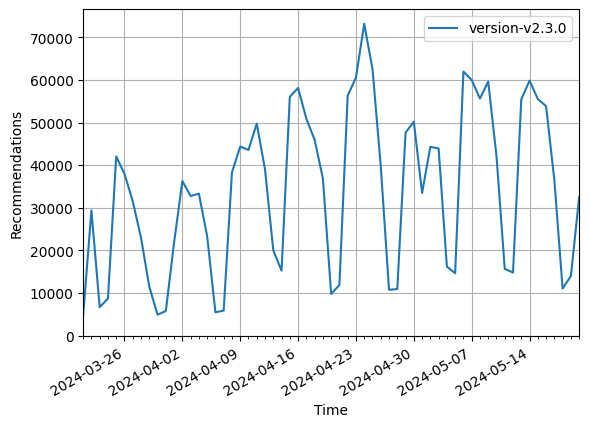

In [34]:
# Global analysis, i.e. keeping eventPeople, Planning, Product, ... altogether (which corresponds to "Per algorithm" since there's no bandit monitoring yet)

pulls = compute_pulls(data, store_time=True)
pulls

display_activity(pulls)

# COMMENT: The graph represents the pulls for Swapcard events in the period 21th March - 20th May 2024.
# We notice a general tendency to 1-week oscillations with minima of events on Sundays and Sundays, maxima generally on Tuesdays and Thursdays.
# There's a local minimum on 01/05 (Labour's day) and a global minimum at the Easter's weekend; 
# the bank holidays of 8-9/5 in France, instead, seem not having influenced the global tendency, which reports a local maximum in these days.

# COMPARISON: Comparing with the period mid september - mid norvember 2023 we observe more variability in the number of recommendations; 
# local minima and local maxima are generally lower than in 2023, showing that in september-november '23 there have been more important events than in march-may '24

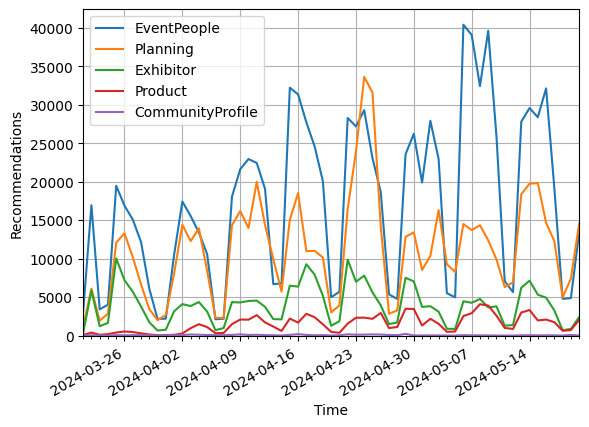

In [35]:
# Per item analysis, i.e. dividing EventPeople, Planning, Product, ...

pulls = compute_pulls(data, tag_extractor=TypeTag(), store_time=True)

display_activity(pulls)

# We notice that usually the number of recommendations are EventPeople > Planning > Exhibitor > Product.
# There are some days (April 22-25th plus some sundays and saturdays) in which we have more Planning recommendations than EventPeople recommendations, though.
# This could be due to events with a lot of sessions (compared to others) taking place in those days, and to the presence of participants more in line with the proposed sessions; 
# for example, in the period mid September - mid November '23 this did not happen.

## e) Impact of the features on the click rate, i.e. quality

In [13]:
def display_rates(rates, data_name='moving_avg', y_label='Click rate', pruning=400):
    fig, ax = plt.subplots(1, 1)
    for tag, stats in rates.items():
        rate = stats[data_name][::pruning]
        if 'time' in stats:
            ax.plot(stats['time'][::pruning], rate, label=tag)
        else:
            ax.plot(np.linspace(0, 1, len(rate)), rate, label=tag)
    plt.ylim([0, None])
    if 'time' in stats:
        plt.xlim([stats['time'][0], stats['time'][-1]])
        fig.autofmt_xdate()
        ax.xaxis.set_major_locator(WeekdayLocator())
        ax.xaxis.set_minor_locator(DayLocator())
    else:
        plt.xlim([0, 1])
    plt.ylabel(y_label)
    plt.xlabel('Time')
    if len(rates) > 1:
        plt.legend()
    ax.grid(True)
    plt.show()


# I define "geometric_average" which is not the usual geoemtric average (x_1 * ... * x_n)^{1/n},
# but instead the ARITHMETIC average but with parameters rho and 1-rho that corresponds to having weights decreasing with geometric distribution.
# Moving average of binary success data to each tag's statistics in the input dictionary.
# Recent successes have a higher influence, and older successes gradually diminish in impact according to the specified decay rate rho.

def geometric_average(pulls, size=1000):
    rho = 1/size
    for tag, stats in pulls.items():
        successes = stats['success']
        moving_avg = np.zeros(len(successes))                             # n-day moving average = average value in the last n-days period
        for i, s in enumerate(successes):
            moving_avg[i] = (1-rho) * moving_avg[i-1] + rho * int(s)
        pulls[tag]['moving_avg'] = moving_avg


# In order to take into account only what happens now, not old events that would not give a true estimation of what is happening in present time
# Doesn't return anything but modifies pulls (inplace)

        
# The time window is expressed in number of actions (because simpler)

In [5]:
# TIME: Global analysis

pulls = compute_pulls(data, store_time=True)
print(pulls)

geometric_average(pulls, size=10**4)
display_rates(pulls)

NameError: name 'data' is not defined

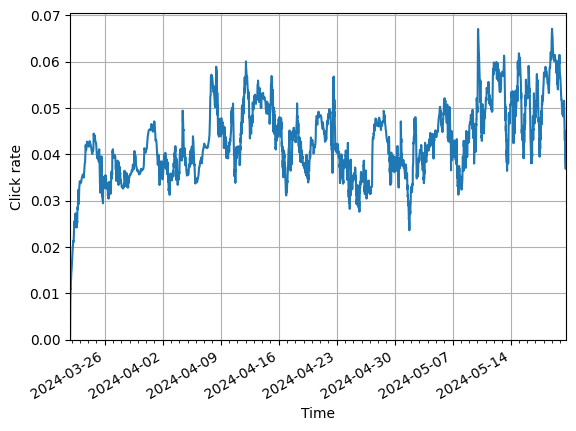

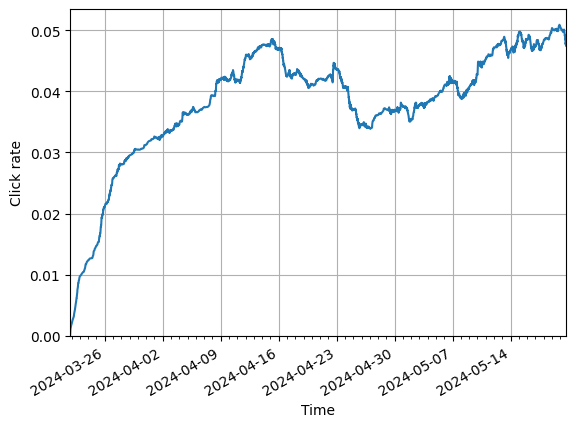

In [ ]:
# Increasing "size" from 10**4 to 10**5, i.e. decreasing frequency, stretches the graph horizontally

geometric_average(pulls, size=10**5)
display_rates(pulls)

# sweet spot = optimum point or combination of factors or qualities [here: point of best efficiency]
# Size 100.000 is a sweet spot in the trade-off between stability of the average and reactivity to changes [solo un modo complicato per dire via di mezzo tra riuscire appena a vedere qualcosa che non sia una linea ed avere un andamento realistico?]

# I notice that the click rate (i.e. the quality of recommendation) is generally between 3 and 5% (quite low, could definitely be improved)
# By increazing the size we lose information, but we notice that in recent time the click rate is preserved

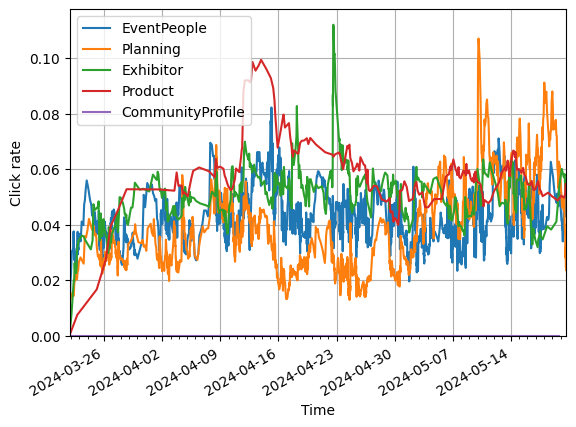

In [40]:
# TIME: Per item analysis

pulls = compute_pulls(data, tag_extractor=TypeTag(), store_time=True)

geometric_average(pulls, size=3000)
display_rates(pulls)

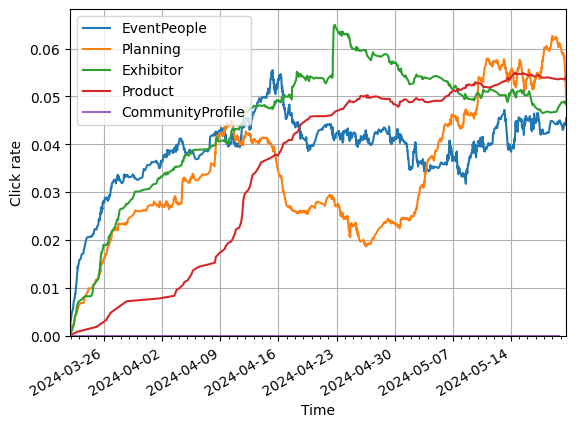

In [41]:
geometric_average(pulls, size=3*10**4)         #3*10**4 is enough
display_rates(pulls)

# The tendency is modified, as the click-through rate gets smoothed. In moving average, you discard the frequencies higher than your moving window to gain in visibility.
# The activity of products (red) is really low, so the characteristic time window for them is much larger than for the rest. This justifies the different tendency of that line.

In [79]:
# My work
# Using pyplot for display and covariance analysis [=seaborn heatmap?]

# DEFINIRE altre funzioni per valutare gli altri feature...



# TIME: per type analysis

In [33]:
# Since I'll use event_dict for type, chategory, ..., size
# ... To be able to use the same geometric_average and display_rates, I define new tag extractors

from mab.tag import TagExtractor

class EventTypeExtractor(TagExtractor):
    """
    Tag by event type.
    """
    def __init__(self, event_dict):
        self.event_dict = event_dict
    def extract(self, r):
        return self.event_dict.get(kind64decode(r['event_id'])[1], {'type': '???'})['type']

In [93]:
pulls = compute_pulls(b, tag_extractor=EventTypeExtractor(event_dict=new_data), store_time=True)
pulls

{'???': {'success': [False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   True,
   True,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   True,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   Fa

In [101]:
{k: len(v['success']) for k, v in pulls.items()}

{'???': 1126465, 'PHYSICAL': 700144, 'HYBRID': 224951, 'VIRTUAL': 25574}

Click rate in time by type of event


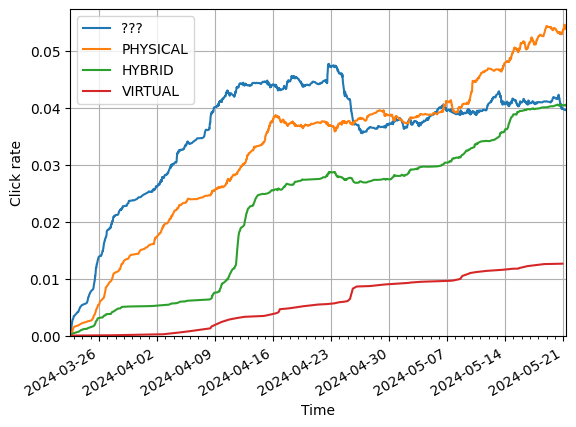

In [97]:
print('Click rate in time by type of event')
geometric_average(pulls, size=100000)        #Fabien up thumbed with 100.000
display_rates(pulls)


# Clicks increasing in time. 
# Despite having the possibility to get to know products, other participants, etc. live at the event, 
# users of pytical events are the ones clicking more. Similar for hybrid.
# Almost no success for recommendations about virtual.

In [38]:
# TIME: per sector analysis 

class EventSectorExtractor(TagExtractor):
    """
    Tag by event sector
    """
    def __init__(self, event_dict):
        self.event_dict = event_dict
    def extract(self, r):
        return self.event_dict.get(kind64decode(r['event_id'])[1], {'sector': '???'})['sector']

In [39]:
# I indtroduce different line styles to make it readable

import random 

def readable_display_rates(rates, data_name='moving_avg', y_label='Click rate', pruning=400):
    fig, ax = plt.subplots(1, 1)
    styles = ['-', '--', '-.', ':']
    for tag, stats in rates.items():
        rate = stats[data_name][::pruning]
        if 'time' in stats:
            ax.plot(stats['time'][::pruning], rate, linestyle=random.choice(styles), label=tag)
        else:
            ax.plot(np.linspace(0, 1, len(rate)), rate, linestyle=random.choice(styles), label=tag)
    plt.ylim([0, None])
    if 'time' in stats:
        plt.xlim([stats['time'][0], stats['time'][-1]])
        fig.autofmt_xdate()
        ax.xaxis.set_major_locator(WeekdayLocator())
        ax.xaxis.set_minor_locator(DayLocator())
    else:
        plt.xlim([0, 1])
    plt.ylabel(y_label)
    plt.xlabel('Time')
    if len(rates) > 1:
        plt.legend()
    ax.grid(True)
    plt.show()

Click rate in time by sector of event


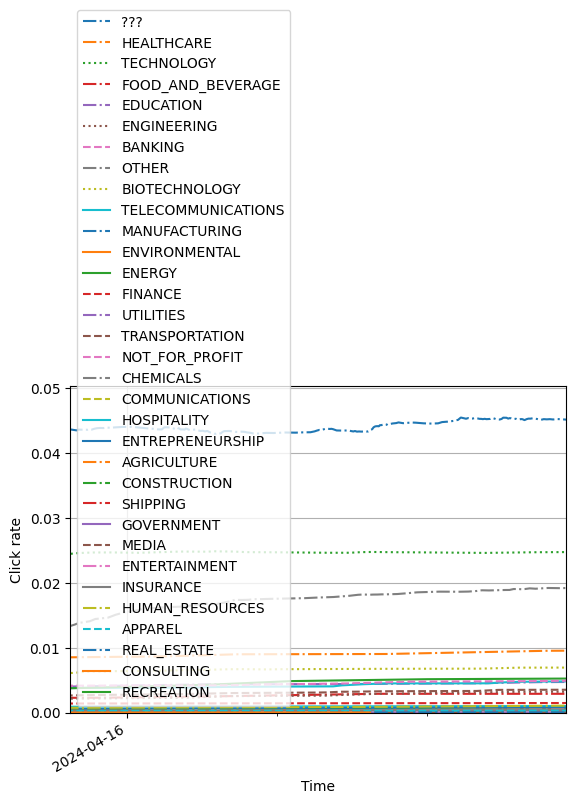

In [119]:
print('Click rate in time by sector of event')
pulls = compute_pulls(b, tag_extractor=EventSectorExtractor(event_dict=new_data), store_time=True)
geometric_average(pulls, size=100000)        
readable_display_rates(pulls)

# Technology is the sector in which we have more clicks, followed by "other", healthcare and biotechnology

# WHAT HAPPENED WITH TIME?

In [ ]:
# Tentative by computing the average for sector and then hystogram

C:\Users\Bonazza Arianna\AppData\Local\Temp\ipykernel_13428\1194846533.py:11: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim([stats['time'][0], stats['time'][-1]])


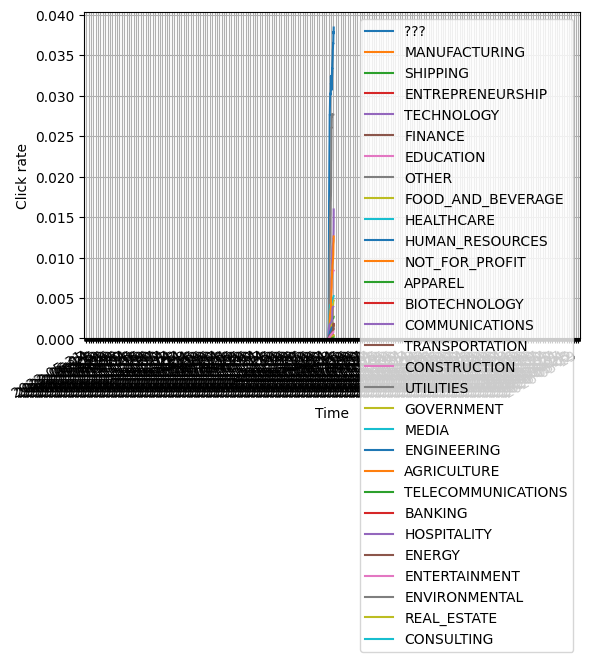

In [40]:
class EventBySectorExtractor(TagExtractor):
    """
    Tag by event sector
    """
    def __init__(self, event_dict):
        self.event_dict = event_dict
    def extract(self, r):
        try:
            return self.event_dict.get(kind64decode(r['event_id'])[1], {'sector': '???'})['sector'] if kind64decode(r['event_id'])[1]['sector']=='HEALTHCARE' else ''
        except TypeError:
            return 0
        

pulls = compute_pulls(b, tag_extractor=EventSectorExtractor(event_dict=new_data), store_time=True)
geometric_average(pulls, size=100000)        
display_rates(pulls)

# Viene lo stesso di prima...

In [ ]:
# Prima faccio una funzione che per ogni sector considera gli eventi di quel sector e ritorna la media dei click rate per quel sector (somma dei click rate: numero di giorni)
# Poi faccio un istogramma che le riporti dalla piu` bassa alla piu` alta
# oppure tre funzioni solo: s, m, l?

In [ ]:
# REDO by grouping by similar sectors

In [87]:
# SECTOR: per item analysis



# E.g. attendees of virtual events click more on recommendations

In [ ]:
# TIME: per cathegory analysis

class EventCathegoryExtractor(TagExtractor):
    """
    Tag by event cathegory.
    """
    def __init__(self, event_dict):
        self.event_dict = event_dict
    def extract(self, r):
        return self.event_dict.get(kind64decode(r['event_id'])[1], {'category': '???'})['category']
        
# CATHERGORY: per item analysis

Click rate in time by category of event


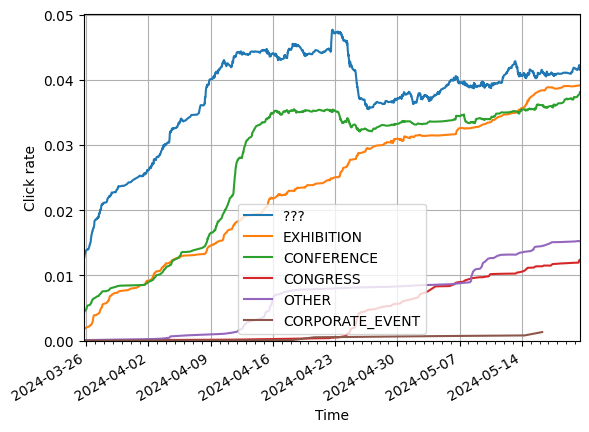

In [122]:
print('Click rate in time by category of event')
pulls = compute_pulls(b, tag_extractor=EventCathegoryExtractor(event_dict=new_data), store_time=True)
geometric_average(pulls, size=100000)        
display_rates(pulls)

# The types of event with more clicks are conferences and exhibitions. Less clicks for 'other' and congresses. Almost no clicks for corporate events. 
# No data in the last days for corporate events

C:\Users\Bonazza Arianna\AppData\Local\Temp\ipykernel_13428\1194846533.py:11: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim([stats['time'][0], stats['time'][-1]])


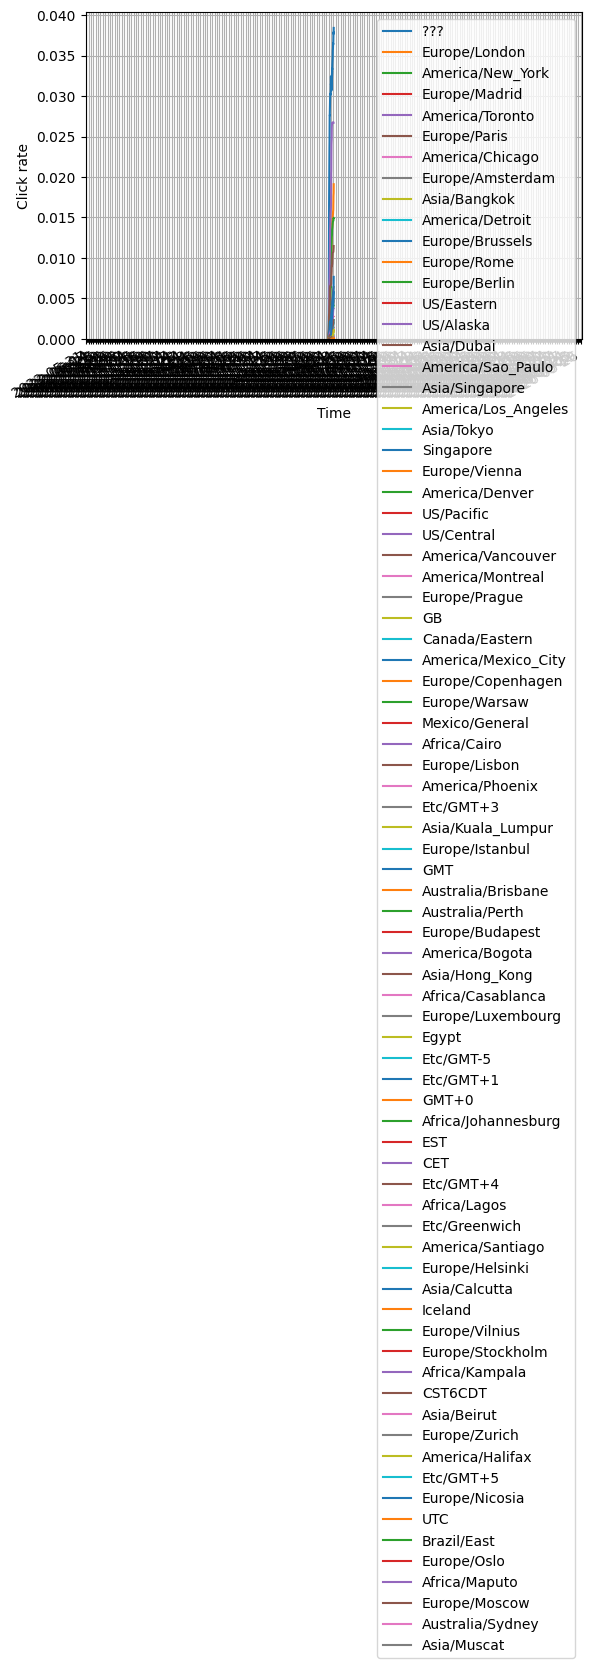

In [36]:
# USELESS - TIME: per timezone analysis (too many timezones)

# Could be redone by grouping by continent


class EventTimeZoneExtractor(TagExtractor):
    """
    Tag by event timezone.
    """
    def __init__(self, event_dict):
        self.event_dict = event_dict
    def extract(self, r):
        try:
            return self.event_dict.get(kind64decode(r['event_id'])[1], {'timezone': '???'})['timezone']
        except TypeError:
            return 0

        
# TIME ZONE: per item analysis

pulls = compute_pulls(b, tag_extractor=EventTimeZoneExtractor(event_dict=new_data), store_time=True)
geometric_average(pulls, size=100000)        
display_rates(pulls)


# e.g. Europe/London and Europe/Dublin, Europe/Lisbon are the same, Europe/Paris and Europe/Amsterdam, Europe/Brussels, Europe/Rome, Europe/Budapest are the same 


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



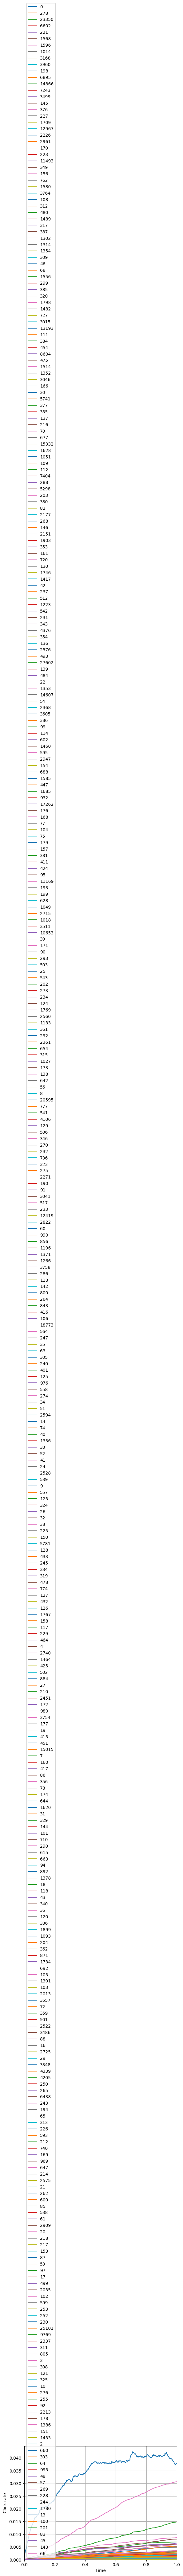

In [119]:
# USELESS - TIME: per size analysis (too many sizes)

class EventSizeExtractor(TagExtractor):
    """
    Tag by event size.
    """
    def __init__(self, event_dict):
        self.event_dict = event_dict
    def extract(self, r):
        try:
            return self.event_dict.get(kind64decode(r['event_id'])[1], {'size': 0})['size']
        except TypeError:
            return 0
            


pulls = compute_pulls(b, tag_extractor=EventSizeExtractor(event_dict=new_data))
print(pulls)
geometric_average(pulls, size=100000)        
display_rates(pulls)

In [43]:
# Tentative of REDOing it by grouping by size 1-5000 (s), 5000-10.000 (m), 10.000+ (l)


# I sorted the list by size and then tried to write a tagextractor for that but it's not working

# Sorting the list by the 'size' key
# Providing a default value IF 'size' is MISSING

sorted_new_data_list = sorted(new_data_list, key=lambda x: x.get('size', 0))
sorted_new_data_list

[{'id': 1775708,
  'type': 'HYBRID',
  'sector': 'ENTREPRENEURSHIP',
  'category': 'EXHIBITION',
  'timezone': 'Asia/Calcutta'},
 {'id': 1778408,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 {'id': 1782207,
  'type': 'HYBRID',
  'sector': 'BANKING',
  'category': 'OTHER',
  'timezone': 'Africa/Casablanca'},
 {'id': 1795696,
  'type': 'HYBRID',
  'sector': 'COMMUNICATIONS',
  'category': 'CONFERENCE',
  'timezone': 'Europe/Oslo'},
 {'id': 1798290,
  'type': 'HYBRID',
  'sector': 'GOVERNMENT',
  'category': None,
  'timezone': 'Africa/Casablanca'},
 {'id': 1798293,
  'type': 'HYBRID',
  'sector': 'AGRICULTURE',
  'category': None,
  'timezone': 'Africa/Casablanca'},
 {'id': 1800453,
  'type': 'VIRTUAL',
  'sector': 'AGRICULTURE',
  'category': 'CONGRESS',
  'timezone': 'America/Buenos_Aires'},
 {'id': 1819561,
  'type': 'HYBRID',
  'sector': 'CONSTRUCTION',
  'category': 'CONFERENCE',
  'timezone': 'Europe/Bratislava'},
 {'id': 1833914,
  't

In [44]:
class list_EventSizeExtractor(TagExtractor):
    """
    Tag by event size.
    """
    def __init__(self, event_list):
        self.event_list = event_list

    def extract(self, r):
        event_id = kind64decode(r['event_id'])[1]
        for event in self.event_list:
            if event['id'] == event_id:
                return event.get('size', '???')
        return '???'

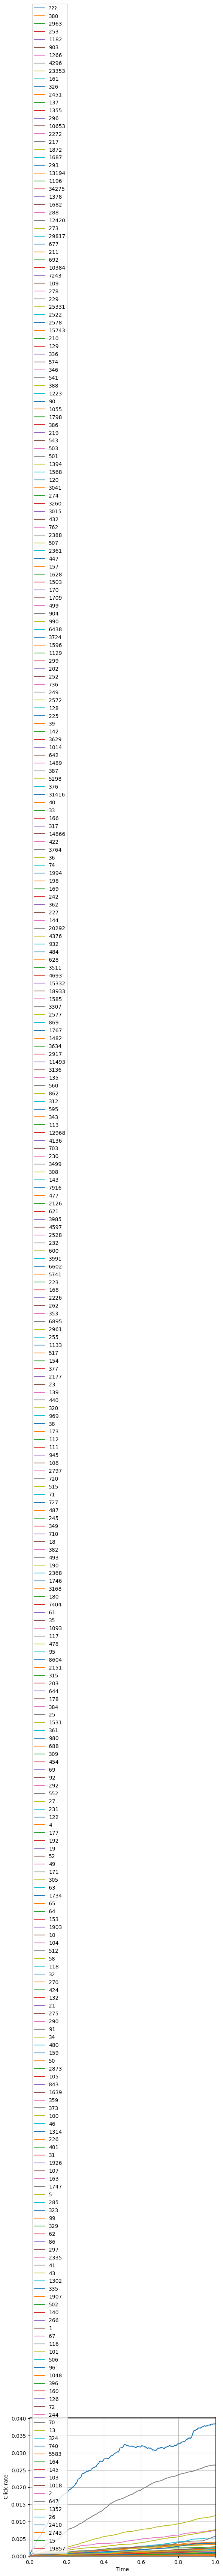

In [45]:
pulls = compute_pulls(b, tag_extractor=list_EventSizeExtractor(event_list=sorted_new_data_list))
geometric_average(pulls, size=100000)        
display_rates(pulls)

# Viene lo stesso di prima...

# You can do it and see how it goes, but I'd like you to explore other options

In [ ]:
# per Giulia: hanno gia divizione S,m,l and timezone?
# non obbligatorio metterw info?

## f) Most important features




In [ ]:
# Determine which features are the most important. 
# Correlation matrix: try to find out if there are cross-correlations.
# Eexamples: 
# - size and type play a role but you also find a big correlation between event size and event type so that the impact of type is just a side-effect of the impact of size
# - size depends on season. But is it really depending only on time?

In [85]:
b

[{'type': 'recommendation_carousel_show',
  'user_id': 'VXNlcl8xMzY5NzA3MA==',
  'platform': 'web-user',
  'time': datetime.datetime(2024, 4, 22, 14, 33, 27, 992157, tzinfo=datetime.timezone.utc),
  'event_id': 'RXZlbnRfMTU1OTk0Ng==',
  'properties': {'source': 'attendee_view',
   'metadata': '{}',
   'is_initial': True,
   'event_view_id': 'RXZlbnRWaWV3XzYxNDIwNQ==',
   'visible_area_end': 0.3826,
   'visible_area_start': 0,
   'current_visible_ids': ['RXZlbnRQZW9wbGVfMjk5ODU5MTg=',
    'RXZlbnRQZW9wbGVfMjk2MzY5MDQ=',
    'RXZlbnRQZW9wbGVfMjk1NDI1NjA=',
    'RXZlbnRQZW9wbGVfMjgzNDkwMTU=']}},
 {'type': 'recommendation_carousel_show',
  'user_id': 'VXNlcl8zODUwMTE=',
  'platform': 'web-user',
  'time': datetime.datetime(2024, 4, 22, 14, 33, 29, 661161, tzinfo=datetime.timezone.utc),
  'event_id': 'RXZlbnRfMTU3MDAwNA==',
  'properties': {'source': 'exhibitor_view',
   'metadata': '{}',
   'is_initial': False,
   'event_view_id': 'RXZlbnRWaWV3XzY5MDMxMA==',
   'visible_area_end': 0.6957,


In [75]:
new_data

{128857: {'id': 128857,
  'type': 'PHYSICAL',
  'sector': 'AGRICULTURE',
  'category': 'OTHER',
  'timezone': 'Europe/Paris',
  'size': 1},
 128859: {'id': 128859,
  'type': 'HYBRID',
  'sector': 'AGRICULTURE',
  'category': 'OTHER',
  'timezone': 'Europe/Paris',
  'size': 1},
 128861: {'id': 128861,
  'type': 'VIRTUAL',
  'sector': 'AGRICULTURE',
  'category': 'OTHER',
  'timezone': 'Europe/Paris',
  'size': 1},
 128867: {'id': 128867,
  'type': 'HYBRID',
  'sector': 'AGRICULTURE',
  'category': 'OTHER',
  'timezone': 'Europe/Paris',
  'size': 1},
 128870: {'id': 128870,
  'type': 'PHYSICAL',
  'sector': 'AGRICULTURE',
  'category': 'OTHER',
  'timezone': 'Europe/Paris',
  'size': 1},
 128872: {'id': 128872,
  'type': 'HYBRID',
  'sector': 'AGRICULTURE',
  'category': 'OTHER',
  'timezone': 'Europe/Paris',
  'size': 1},
 128873: {'id': 128873,
  'type': 'VIRTUAL',
  'sector': 'AGRICULTURE',
  'category': 'OTHER',
  'timezone': 'Europe/Paris',
  'size': 1},
 128877: {'id': 128877,
  't

In [6]:
import pandas as pd

In [23]:
df = pd.DataFrame.from_dict(new_data, orient='index')
df

id      type      sector  category        timezone   size
1765467  1765467  PHYSICAL        None      None    Europe/Paris  140.0
1765468  1765468  PHYSICAL        None      None    Europe/Paris    1.0
1765508  1765508  PHYSICAL        None      None    Europe/Paris  140.0
1765509  1765509  PHYSICAL        None      None    Europe/Paris    1.0
1765558  1765558  PHYSICAL        None      None    Europe/Paris  139.0
...          ...       ...         ...       ...             ...    ...
1905797  1905797  PHYSICAL        None      None    Europe/Paris    1.0
1905822  1905822    HYBRID  HEALTHCARE  CONGRESS    Europe/Paris    1.0
1905846  1905846  PHYSICAL        None      None    Europe/Paris  108.0
1905848  1905848  PHYSICAL        None      None    Europe/Paris    1.0
1905862  1905862  PHYSICAL       OTHER      None  Africa/Kampala   21.0

[10610 rows x 6 columns]

In [131]:
df.duplicated().sum()

0

In [27]:
df.isnull().sum()

id            0
type          0
sector       44
category    223
timezone      0
dtype: int64

In [35]:
df['size'].describe()

# Average size of Swapcard events is 81 participants, but the standard deviation is 687 (gigantic). 75% of events have less than 7 participants!

count    11138.000000
mean         2.200485
std         44.524355
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       4007.000000
Name: size, dtype: float64

In [28]:
import seaborn as sns

Boxplot of size


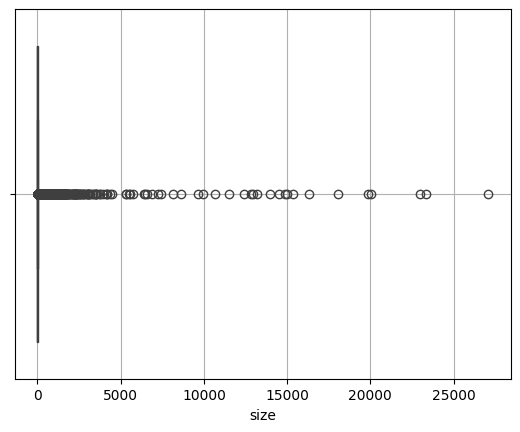

In [165]:
print('Boxplot of size')
sns.boxplot(x=df['size'])
plt.grid()

Size vs. type


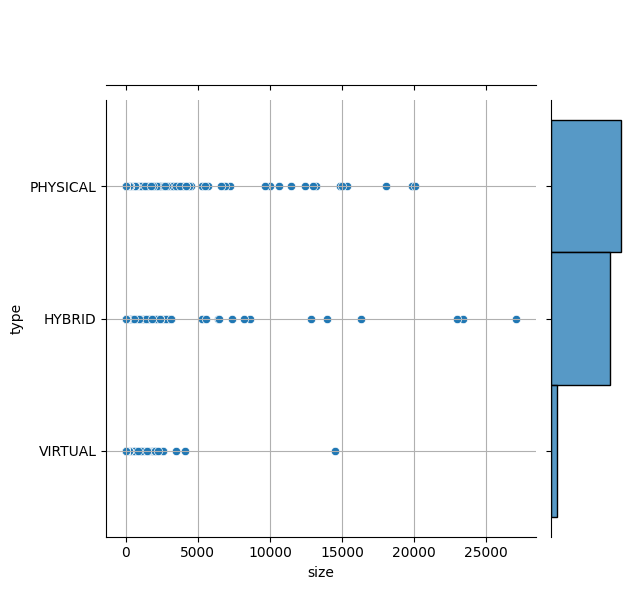

In [180]:
print('Size vs. type')
#plt.figure(figsize=(40,6))
sns.jointplot(x='size', y='type', data=df)
plt.grid()
plt.show()

# Physical modality was the most chosed. Physical events had in general less than 7500 partecipants, never more than 20.500 for space reasons. 
# Hybrid modality suitable even for very big events.
# Virtual events were very small: below 5000 partecipants. 

Size vs. sector


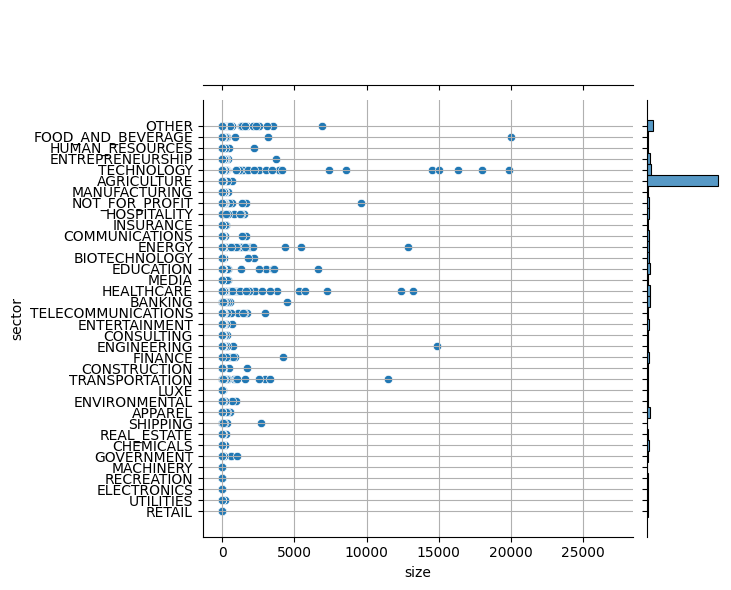

In [179]:
print('Size vs. sector')
#plt.figure(figsize=(40,6))
sns.jointplot(x='size', y='sector', data=df)
plt.grid()
plt.show()

# Swapcard's events mostly in the technology sector and below 5000 participants

Size vs. category


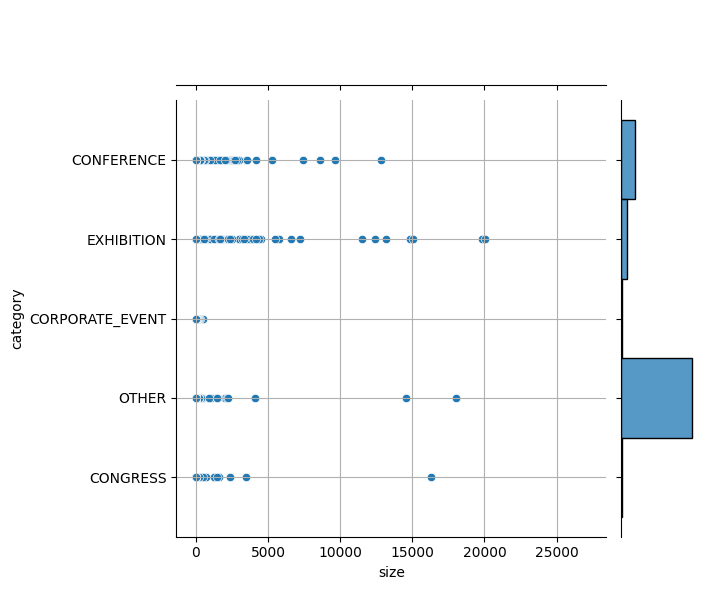

In [187]:
print('Size vs. category')
#plt.figure(figsize=(40,6))
sns.jointplot(x='size', y='category', data=df)
plt.grid()
plt.show()

# Swapcard's events mostly of category "other' (followed by conference and ehibition) and below 5000 participants

In [46]:
# Let's etrapolate multiple dimention data:  size vs. click rate

In [186]:
df['category'].value_counts()

category
OTHER              5089
CONFERENCE          988
EXHIBITION          421
CONGRESS            106
CORPORATE_EVENT     100
Name: count, dtype: int64

In [62]:
# Sample data
values_a = df['size']
pulls = compute_pulls(b, tag_extractor=EventSizeExtractor(event_dict=new_data))

print(values_a)

1765467    140.0
1765468      1.0
1765508    140.0
1765509      1.0
1765558    139.0
           ...  
1950153      1.0
1950607      1.0
1950669      1.0
1950691      1.0
1950696      1.0
Name: size, Length: 13990, dtype: float64


In [78]:
# List comprehension to get 'size' or default to 0
sizes = [event.get('size', 0) for event in new_data.values()]
sizes

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 6,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [27]:
len(sizes)

14081

In [79]:
mod_pulls

[(datetime.datetime(2024, 5, 13, 16, 40, 38, 576179, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMTkxMDg0OA==',
  False),
 (datetime.datetime(2024, 5, 13, 16, 40, 38, 733195, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMTUzMDc3NA==',
  False),
 (datetime.datetime(2024, 5, 13, 16, 40, 38, 827559, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMTY5NTk1NA==',
  False),
 (datetime.datetime(2024, 5, 13, 16, 40, 39, 643877, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMTY3OTc2Mw==',
  False),
 (datetime.datetime(2024, 5, 13, 16, 40, 40, 680989, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMTY5NTk1NA==',
  False),
 (datetime.datetime(2024, 5, 13, 16, 40, 42, 671043, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMTUzOTAyNA==',
  False),
 (datetime.datetime(2024, 5, 13, 16, 40, 43, 826343, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMTc4MTYwNg==',
  False),
 (datetime.datetime(2024, 5, 13, 16, 40, 43, 884918, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMTY3OTc2Mw==',
  False),
 (datetime.datetime(2024, 5, 13, 16, 40,

In [25]:
# Fabien

from collections import Counter

event_stats = Counter((kind64decode(r[1])[1], r[2]) for r in mod_pulls)
event_stats

Counter({(1539024, False): 37815,
         (1790921, False): 26577,
         (1786043, False): 26079,
         (1893496, False): 23689,
         (1914830, False): 18351,
         (1695954, False): 17361,
         (1410138, False): 17052,
         (1709722, False): 15319,
         (1867527, False): 14957,
         (1728371, False): 14411,
         (1781606, False): 13890,
         (1487800, False): 13558,
         (1862604, False): 13122,
         (1831071, False): 9990,
         (1679763, False): 8306,
         (1905035, False): 7901,
         (1564435, False): 7794,
         (1867785, False): 7032,
         (1380187, False): 6554,
         (1894010, False): 6420,
         (1794212, False): 6311,
         (1493068, False): 6153,
         (1858058, False): 5578,
         (1696002, False): 5564,
         (1767936, False): 5293,
         (1790667, False): 4956,
         (1585644, False): 4576,
         (1904380, False): 4290,
         (1530774, False): 4114,
         (1798670, False): 399

In [26]:
# Fabien

cr = dict()
for event_value in event_stats:
    e = event_value[0]
    if e not in cr:
        trues = event_stats.get((e, True), 0)
        falses = event_stats.get((e, False), 0)
        cr[e] = trues/(trues+falses)                             # successi / totali

cr

{1529889: 0.05190311418685121,
 1774837: 0.04286185295087372,
 1856210: 0.1125,
 1849574: 0.051787916152897656,
 1695954: 0.04405043775122515,
 1062438: 0.0,
 1794810: 0.04109994086339444,
 1410138: 0.04234527687296417,
 1914830: 0.042922707833524566,
 1905035: 0.04531174480425326,
 1862523: 0.04596191726854892,
 1792779: 0.018867924528301886,
 1856278: 0.04776119402985075,
 1679763: 0.05182648401826484,
 1104656: 0.02040816326530612,
 1888546: 0.04527027027027027,
 1851396: 0.04812319538017324,
 1867527: 0.044586394123283295,
 1742419: 0.026785714285714284,
 1711383: 0.045847750865051905,
 1846397: 0.048,
 1743920: 0.05517241379310345,
 1923319: 0.05580215599239061,
 1493068: 0.04987646695491044,
 1726703: 0.051432291666666664,
 1867785: 0.04805739813185326,
 1774696: 0.051818634778276036,
 1739746: 0.030927835051546393,
 1728371: 0.04480678730032478,
 1906528: 0.023346303501945526,
 1784880: 0.053208137715179966,
 1747637: 0.0481283422459893,
 1801922: 0.06542056074766354,
 1786043: 

In [35]:
len(cr)

# Y ONLY 1102???

1102

In [27]:
size={event['id']: event.get('size', 0) for event in new_data.values()}
size

{1765467: 140,
 1765468: 1,
 1765508: 140,
 1765509: 1,
 1765558: 139,
 1765559: 1,
 1765571: 139,
 1765572: 1,
 1765584: 129,
 1765585: 1,
 1765623: 140,
 1765624: 1,
 1765637: 140,
 1765638: 1,
 1765653: 140,
 1765654: 1,
 1765666: 140,
 1765667: 1,
 1765679: 140,
 1765680: 1,
 1765692: 140,
 1765693: 1,
 1765731: 140,
 1765732: 140,
 1765733: 1,
 1765734: 1,
 1765757: 1,
 1765759: 140,
 1765760: 1,
 1765776: 224,
 1765780: 139,
 1765781: 1,
 1765794: 1,
 1765823: 138,
 1765824: 1,
 1765865: 140,
 1765866: 1,
 1765878: 178,
 1765879: 140,
 1765880: 1,
 1765881: 2,
 1765894: 140,
 1765895: 1,
 1765910: 140,
 1765911: 1,
 1765939: 140,
 1765940: 1,
 1765964: 140,
 1765965: 1,
 1766016: 140,
 1766017: 1,
 1766031: 1811,
 1766035: 140,
 1766036: 1,
 1766051: 136,
 1766052: 1,
 1766064: 1,
 1766066: 140,
 1766067: 1,
 1766081: 140,
 1766082: 1,
 1766131: 140,
 1766132: 1,
 1766144: 140,
 1766145: 1,
 1766179: 139,
 1766180: 1,
 1766190: 1,
 1766201: 140,
 1766202: 1,
 1766214: 140,
 17662

In [38]:
len(size)

14081

In [28]:
def populate_data_dict(dict1, dict2):
    data_dict={}
    for k in dict1.keys():
        if k in dict2.keys():
            data_dict[k]=(dict1[k], dict2[k])
    return data_dict
            
data_dict=populate_data_dict(cr, size)       #event_id: (clickrate, size)}
data_dict

{1774837: (0.04286185295087372, 3312),
 1856210: (0.1125, 2226),
 1849574: (0.051787916152897656, 1355),
 1794810: (0.04109994086339444, 709),
 1905035: (0.04531174480425326, 3066),
 1862523: (0.04596191726854892, 903),
 1792779: (0.018867924528301886, 762),
 1856278: (0.04776119402985075, 1568),
 1888546: (0.04527027027027027, 296),
 1851396: (0.04812319538017324, 10653),
 1867527: (0.044586394123283295, 1687),
 1846397: (0.048, 432),
 1867785: (0.04805739813185326, 31450),
 1774696: (0.051818634778276036, 2981),
 1784880: (0.053208137715179966, 252),
 1801922: (0.06542056074766354, 1223),
 1786043: (0.04762078661943542, 4297),
 1772425: (0.045028630921395106, 2272),
 1775015: (0.043123162365240116, 1580),
 1859806: (0.031914893617021274, 541),
 1791300: (0.07894736842105263, 376),
 1839235: (0.047493403693931395, 503),
 1767936: (0.04423979776092452, 23356),
 1790251: (0.014084507042253521, 5298),
 1790667: (0.0511200459506031, 13194),
 1877167: (0.09523809523809523, 129),
 1798670: 

In [29]:
cr_vector = [i[0] for i in data_dict.values()]   # vectors of click rates

In [30]:
size_vector = [i[1] for i in data_dict.values()]     # vectors of sizes

Size vs. click rate


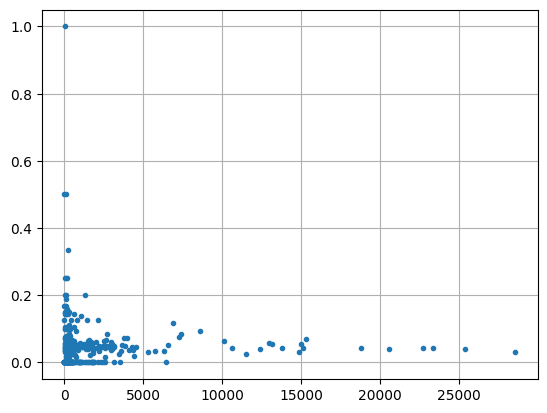

In [57]:
print('Size vs. click rate')
plt.plot(size_vector, cr_vector, '.')
plt.grid()

In [31]:
cr_key_list=list(cr.keys())
cr_key_list.sort()
sorted_cr = {i : cr[i] for i in cr_key_list if i in size.keys()}
sorted_cr

{1765878: 0.0,
 1766349: 0.0,
 1766665: 0.0,
 1767091: 0.07936507936507936,
 1767184: 0.16666666666666666,
 1767936: 0.04423979776092452,
 1768108: 0.0,
 1768268: 0.0,
 1768536: 0.0,
 1769080: 0.03468208092485549,
 1769205: 0.0,
 1769722: 0.0,
 1770410: 0.0,
 1771813: 0.0,
 1772399: 0.0,
 1772425: 0.045028630921395106,
 1772428: 0.0334313005143277,
 1773116: 0.05898876404494382,
 1773411: 0.08333333333333333,
 1773416: 0.045454545454545456,
 1773460: 0.02564102564102564,
 1773612: 0.0,
 1773646: 0.0,
 1773679: 0.0,
 1773682: 0.0,
 1773696: 0.061224489795918366,
 1774119: 0.052132701421800945,
 1774659: 0.05357142857142857,
 1774664: 0.04355165428764349,
 1774686: 0.0,
 1774696: 0.051818634778276036,
 1774720: 0.03849443969204448,
 1774800: 0.07920792079207921,
 1774837: 0.04286185295087372,
 1774847: 0.0,
 1774901: 0.043233082706766915,
 1775015: 0.043123162365240116,
 1775019: 0.0,
 1775163: 0.5,
 1775792: 0.04054054054054054,
 1775794: 0.06451612903225806,
 1775837: 0.061224489795918

In [32]:
df['click rate'] = pd.DataFrame.from_dict(sorted_cr, orient='index')
df

id      type      sector  category        timezone   size  \
1765467  1765467  PHYSICAL        None      None    Europe/Paris  140.0   
1765468  1765468  PHYSICAL        None      None    Europe/Paris    1.0   
1765508  1765508  PHYSICAL        None      None    Europe/Paris  140.0   
1765509  1765509  PHYSICAL        None      None    Europe/Paris    1.0   
1765558  1765558  PHYSICAL        None      None    Europe/Paris  139.0   
...          ...       ...         ...       ...             ...    ...   
1905797  1905797  PHYSICAL        None      None    Europe/Paris    1.0   
1905822  1905822    HYBRID  HEALTHCARE  CONGRESS    Europe/Paris    1.0   
1905846  1905846  PHYSICAL        None      None    Europe/Paris  108.0   
1905848  1905848  PHYSICAL        None      None    Europe/Paris    1.0   
1905862  1905862  PHYSICAL       OTHER      None  Africa/Kampala   21.0   

         click rate  
1765467         NaN  
1765468         NaN  
1765508         NaN  
1765509         NaN  
1765558         NaN  
...             ...  
1905797         NaN  
1905822         NaN  
1905846         NaN  
1905848         NaN  
1905862    0.103448  

[10610 rows x 7 columns]

In [33]:
# Scarico il df per non dover ogni volta caricare i dati
df.to_csv(r"C:\Users\Bonazza Arianna\Desktop\df.csv")

Size vs. clic krate


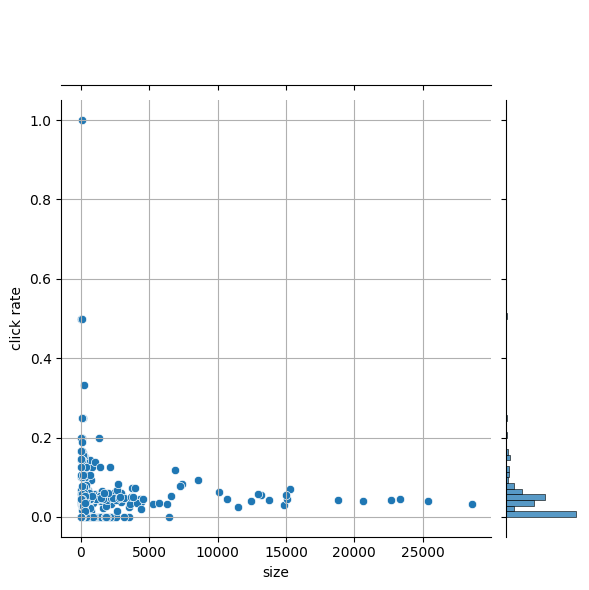

In [61]:
print('Size vs. clic krate')
#plt.figure(figsize=(40,6))
sns.jointplot(x='size', y='click rate', data=df)
plt.grid()
plt.show()

In [40]:
# Discarding events with 0 cr or size: i NaN li lascio
no0df = df[(df[['size','click rate']] != 0).all(axis=1)]
# UNDERSTAND https://codereview.stackexchange.com/questions/185389/dropping-rows-from-a-pandas-dataframe-where-some-of-the-columns-have-value-0
no0df

id      type      sector  category          timezone    size  \
1766031  1766031   VIRTUAL  TECHNOLOGY      None  America/New_York  1811.0   
1766035  1766035  PHYSICAL        None      None      Europe/Paris   140.0   
1766036  1766036  PHYSICAL        None      None      Europe/Paris     1.0   
1766051  1766051  PHYSICAL        None      None      Europe/Paris   136.0   
1766052  1766052  PHYSICAL        None      None      Europe/Paris     1.0   
...          ...       ...         ...       ...               ...     ...   
1905797  1905797  PHYSICAL        None      None      Europe/Paris     1.0   
1905822  1905822    HYBRID  HEALTHCARE  CONGRESS      Europe/Paris     1.0   
1905846  1905846  PHYSICAL        None      None      Europe/Paris   108.0   
1905848  1905848  PHYSICAL        None      None      Europe/Paris     1.0   
1905862  1905862  PHYSICAL       OTHER      None    Africa/Kampala    21.0   

         click rate  
1766031         NaN  
1766035         NaN  
1766036         NaN  
1766051         NaN  
1766052         NaN  
...             ...  
1905797         NaN  
1905822         NaN  
1905846         NaN  
1905848         NaN  
1905862    0.103448  

[10419 rows x 7 columns]

Size vs. click rate


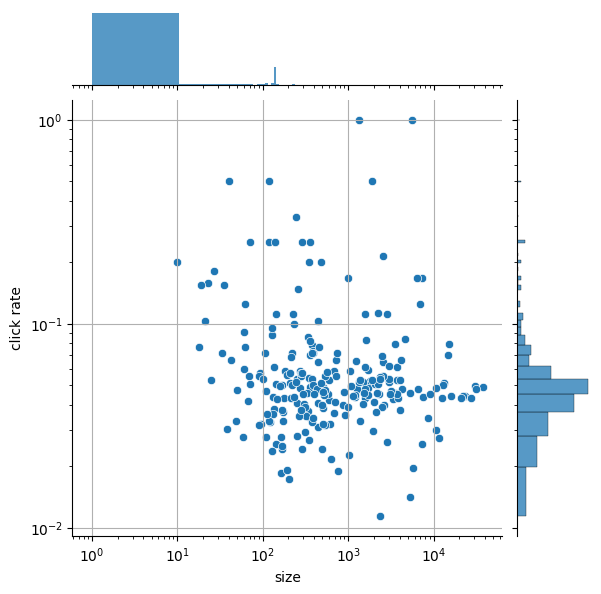

In [37]:
# Loglog plot

print('Size vs. click rate')
#plt.figure(figsize=(40,6))
sns.jointplot(x='size', y='click rate', data=no0df)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.show()

# The problem is that for a lot of events the cr are NaN

In [26]:
# Discarding events with NaN cr or size
no0noNaNdf=no0df.dropna(subset=['click rate'])
no0noNaNdf=no0noNaNdf.dropna(subset=['size'])
no0noNaNdf

Unnamed: 0       id      type         sector    category  \
144       1767091  1767091   VIRTUAL          OTHER  CONFERENCE   
150       1767184  1767184    HYBRID     TECHNOLOGY  CONFERENCE   
219       1767936  1767936    HYBRID            NaN         NaN   
309       1769080  1769080  PHYSICAL            NaN         NaN   
639       1772425  1772425    HYBRID            NaN  CONFERENCE   
...           ...      ...       ...            ...         ...   
10397     1904681  1904681  PHYSICAL     HEALTHCARE    CONGRESS   
10408     1904896  1904896  PHYSICAL            NaN         NaN   
10423     1905035  1905035  PHYSICAL       SHIPPING  CONFERENCE   
10458     1905612  1905612  PHYSICAL  MANUFACTURING  CONFERENCE   
10468     1905862  1905862  PHYSICAL          OTHER         NaN   

               timezone     size  click rate  
144       Europe/London   3499.0    0.079365  
150    America/New_York   7404.0    0.166667  
219        Europe/Paris  23356.0    0.044240  
309       Europe/Berlin    351.0    0.034682  
639    America/New_York   2272.0    0.045029  
...                 ...      ...         ...  
10397      Europe/Paris    211.0    0.057303  
10408      Europe/Paris    108.0    0.027933  
10423  America/New_York   3066.0    0.045312  
10458         Etc/GMT+4    112.0    0.035971  
10468    Africa/Kampala     21.0    0.103448  

[242 rows x 8 columns]

Size vs. click rate


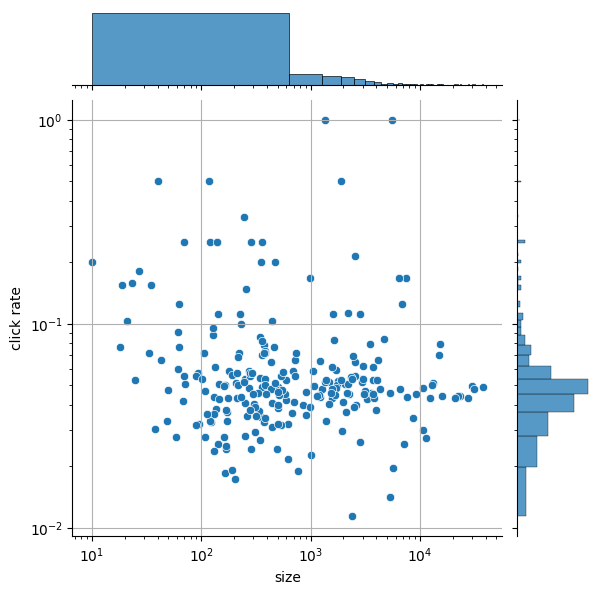

In [31]:
print('Size vs. click rate')
#plt.figure(figsize=(40,6))
sns.jointplot(x='size', y='click rate', data=no0noNaNdf)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.show()

<Axes: >

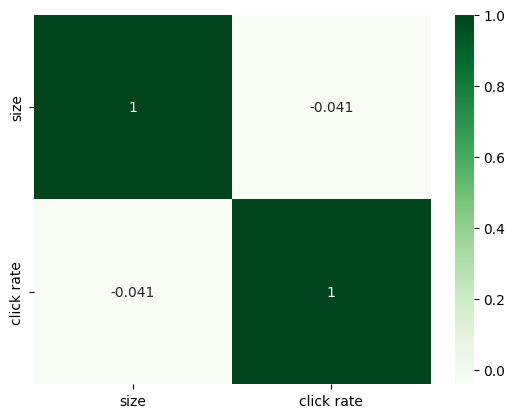

In [36]:
# Correlation matrix - Heatmap

dataframe= no0noNaNdf[['size', 'click rate']]
matrix = dataframe.corr()
sns.heatmap(matrix, cmap="Greens", annot=True)

# Click rate and size SLIGHTLY negatively correlated (-0.041).
# We find out that in big events attendees are less interested in networking, so it's less likely that they click on recommendations

In [ ]:
# Nonetheless, as said above, for many events the cr is NaN (i.e. can't be calculated).
# Doing the math we find out that hence we just considered 2.3% of the events (the ones with rational and not null size and cr).
# Opening the database (to find a pattern) we find out that a lot of recommendations have event_id "null". The reason of this should be investigated.